# Data Dictionary

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
# importing required libraries
import pandas as pd
import numpy as np

In [2]:
# importing csv data into a dataframe
data = pd.read_csv('C:\\Users\\Dell\\Downloads\\Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Cleaning
#### 1. Handling missing data
#### 2. Handling inconsistant data
#### 3. Handling outliers
## Missing data

In [3]:
# checking for missing values in the data
data.isnull().values.any()
# if True then there are missing values and if false there are no missing values

False

the result is false so there are no missinng values in the dataset

# Inconsistant data
#### 1. Consistancy of datatypes of variables

In [4]:
# checking data type consistensy in each column of data i.e. each variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


so the variables step, amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud have consistant data types which is int64 or float64

now we need to check for the datatypes object in variables type, nameOrig, nameDest have consists of same dtype

In [5]:
# checking if variable 'type' has any other object type other than 'str'
(data['type'].map(type) != str).values.any()
# if returned true there are 'type' variable consists object types other than 'str'

False

In [6]:
# checking if variable 'nameOrig' has any other object type other than 'str'
(data['nameOrig'].map(type) != str).values.any()
# if returned true there are 'type' variable consists object types other than 'str'

False

In [7]:
# checking if variable 'nameDest' has any other object type other than 'str'
(data['nameDest'].map(type) != str).values.any()
# if returned true there are 'nameDest' variable consists object types other than 'str'

False

so the dtypes are consistant across the variables 'type', 'nameOrig', 'nameDest'

# 2. Duplicate data

In [8]:
# finding dupicate data and getting total number of duplicated data
data.duplicated().sum()
# returns number of duplicate data

0

so there is no duplication in the data

# 3. validity
is the data consistant with the rules.

Possible rules that apply here are related to transaction numbers like amount, orig balances and dest balances. The rule also depend on the type of transaction

In [9]:
data['type'].value_counts()

CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: type, dtype: int64

there same errors in newbalanceOrig and newbalanceDest, so for correcting this validity error we add extra 2 features errorbalanceOrig and errorbalanceDest

errorbalanceOrig = (newbalanceOrig + amount) - oldbalanceOrig
errorbalanceDest = (newbalanceDest + amount) - oldbalanceDest

In [10]:
data['errorbalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorbalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

# Data Analysis and Visualization

In [11]:
# importing libs/modules required for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# getting the number of fraud examples and number of not fraud examples
n_fraud  = data['isFraud'].value_counts()
n_fraud

0    1047433
1       1142
Name: isFraud, dtype: int64

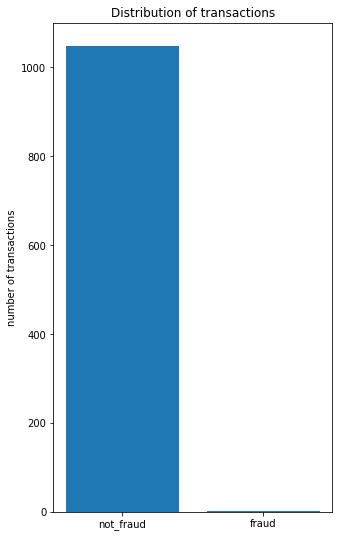

In [13]:
# bar plot of count of fraud vs not fraud in thousands
nf_plot = plt.figure(figsize=(5,9))
plt.bar(['not_fraud','fraud'],n_fraud.values/1000)
plt.title('Distribution of transactions')
plt.ylabel('number of transactions')
plt.show()

ths shows that the data is highly imbalanced as the number of not_fraud examples are very very large when compared to number fraud examples. thus we must use resampling techniques to balance the data

In [14]:
# getting count of transaction types in fraud data
t_fraud_s = data[data['isFraud'] == 1]['type'].value_counts()
t_fraud_s
# returns transaction type and number fraud examples for each type

CASH_OUT    578
TRANSFER    564
Name: type, dtype: int64

In [15]:
t_fraud = []
for t in ['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT' ]:
    try:
        t_fraud.append(t_fraud_s[t])
    except:
        t_fraud.append(0)

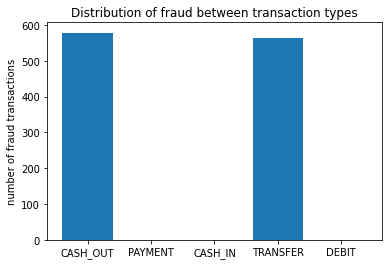

In [16]:
tf_plot = plt.figure()
plt.bar(['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT' ],t_fraud)
plt.title('Distribution of fraud between transaction types')
plt.ylabel('number of fraud transactions')
plt.show()

the fraud examples are equally distributed betwenn the types 'CASH_OUT', 'TRANSFER' but other transaction types do not contain any fraudulent transactions. this show that fraudulent transactions are only occuring within transaction types CASH_OUT and TRANSFER.

this conveys that transaction types other than 'CASH_OUT', 'TRANSFER' have no relevence to fraud transactions, so examples with these types can be removed before training data. the algorithm if would if transaction type not 'CASH_OUT', 'TRANSFER' not fraudulent transaction else run the data into machine learning model to predict wether the transaction is fraud or not

In [17]:
# count of each payment type
data['type'].value_counts()

CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: type, dtype: int64

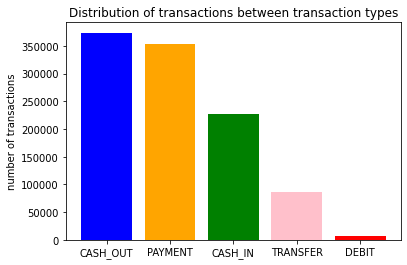

In [18]:
# plot of transaction type distribution
plot = plt.figure()
plt.bar(data['type'].value_counts().index,data['type'].value_counts().values, color = ['blue','orange','green','pink','red'])
plt.title('Distribution of transactions between transaction types')
plt.ylabel('number of transactions')
plt.show()


this shows that cash out is the most used transaction type and debit being least used trasaction type.

expected no. of fraud per 10000 transactions for individual type =
total no. of frauds in indivitual transaction type / total no. of transactions of individual type

In [19]:
# calculating occurence of fraud per 1000 transactions
(t_fraud_s/data['type'].value_counts()[['CASH_OUT','TRANSFER']])*1000

CASH_OUT    1.546939
TRANSFER    6.501216
Name: type, dtype: float64

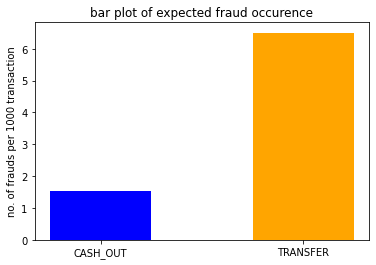

In [20]:
tf_plot = plt.figure()
plt.bar((t_fraud_s/data['type'].value_counts()[['CASH_OUT','TRANSFER']]).index,(t_fraud_s/data['type'].value_counts()[['CASH_OUT','TRANSFER']]).values*1000, color = ['blue','orange'], width = 0.5)
plt.title('bar plot of expected fraud occurence')
plt.ylabel('no. of frauds per 1000 transaction')
plt.show()

In [21]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorbalanceOrig,errorbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,11668.14


# data preparation for model training

In [22]:
model_data = data[(data['type'] == 'CASH_OUT') | (data['type'] == 'TRANSFER')]
model_data = model_data.drop(['nameOrig','nameDest'],axis = 1)
model_data['type'].replace('TRANSFER', 0, inplace = True)
model_data['type'].replace('CASH_OUT', 1, inplace = True)

In [23]:
model_y = model_data['isFraud']
model_x = model_data.drop(['isFraud'],axis = 1)

In [24]:
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

# resampling of data using SMOTE
# SMOTE : Synthatic Minority Over-Sampling Technique

In [25]:
x_resample, y_resample = SMOTE().fit_resample(model_x, model_y.values.ravel())

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size = 0.1, random_state = 0)

In [27]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# model selection and training

# logistic regresion

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [30]:
# metrics
print('accuracy : {}'.format(model.score(x_test,y_test)))
print('average precision score : {}'.format(average_precision_score(y_test,y_pred)))
print('confusion matrix :\n  {}'.format(confusion_matrix(y_test,y_pred)))
print('classification report :')
print(classification_report(y_test,y_pred))

accuracy : 0.9348945574898477
average precision score : 0.9099508964264172
confusion matrix :
  [[43773  2483]
 [ 3497 42098]]
classification report :
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     46256
           1       0.94      0.92      0.93     45595

    accuracy                           0.93     91851
   macro avg       0.94      0.93      0.93     91851
weighted avg       0.94      0.93      0.93     91851



# MLP Classifier (Neural Network)
# MLP : Multi Layer Perceptron Classifier
### Perceptron is an algorithm for supervised learning of binary classifiers. A binary classifier is a function which can decide whether or not an input, represented by a vector of numbers, belongs to some specific class.

In [35]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier([10,25,10])
model.fit(x_train,y_train)
y_pred = model.predict(x_test)  

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [34]:
# metrics
print('accuracy : {}'.format(model.score(x_test,y_test)))
print('average precision score : {}'.format(average_precision_score(y_test,y_pred)))
print('confusion matrix :\n  {}'.format(confusion_matrix(y_test,y_pred)))
print('classification report :')
print(classification_report(y_test,y_pred))

accuracy : 0.9837671881634387
average precision score : 0.9821679209020504
confusion matrix :
  [[46130   126]
 [ 1365 44230]]
classification report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     46256
           1       1.00      0.97      0.98     45595

    accuracy                           0.98     91851
   macro avg       0.98      0.98      0.98     91851
weighted avg       0.98      0.98      0.98     91851



# XGBoost Classifier

## XGBoost stands for Extreme Gradient Boosting, is a scalable, distributed, gradient boosted decision tree(GBDT) machine learning library. It provides parellel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
# metrics
print('accuracy : {}'.format(model.score(x_test,y_test)))
print('average precision score : {}'.format(average_precision_score(y_test,y_pred)))
print('confusion matrix :\n  {}'.format(confusion_matrix(y_test,y_pred)))
print('classification report :')
print(classification_report(y_test,y_pred))

accuracy : 0.9993358809376055
average precision score : 0.9989566443218838
confusion matrix :
  [[46222    34]
 [   27 45568]]
classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46256
           1       1.00      1.00      1.00     45595

    accuracy                           1.00     91851
   macro avg       1.00      1.00      1.00     91851
weighted avg       1.00      1.00      1.00     91851



# THANK YOU